In [ ]:
#Step 1: Run to import necessary modules

from PIL import Image
from itertools import product
import os
import statistics
from PIL import Image
from collections import Counter
from datetime import datetime
import numpy as np
from sklearn import metrics 
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import re

In [ ]:
#Step 2: Run to define data directories, colour lists, and methods that are used throughout script 
currentDirectory = os.getcwd()
satelliteImageDir = 'data\\Satellite_images_test'
imageTileDir = 'data\\SegmentedImages_test'
mappedFullImages = 'data\\mapped\\Satellite_images_test'

print("Current Working Directory:", currentDirectory)

def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    if re.search(r"tile_\d+", name):
    # Extract the tile number
        match = re.search(r"tile_(\d+)", name)
        tileNum = int(match.group(1))  # Extracted number as a string
        print(f"Tile number found: {tileNum}")
    else:
        print("No tile number found in the name.")
        tileNum = 0;
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{name}_tile_{tileNum}{ext}')
        img.crop(box).save(out)
        if d == 64:
            tileNum += 4
        else:
            tileNum +=1
    print(filename)
    print(dir_in)

# Define a list of target colours in RGB format
target_colours = [
    (92, 80, 80),    # Medium Brown
    (66, 52, 52),    # Dark Brown
    (82, 110, 81),    # Green
    (0,0,0),  # Black
    (224, 224, 224)  # White
]

target_colours_names = [
    'Medium_Brown',    # Medium Brown
    'Dark_Brown',    # Dark Brown
    'Green',    # Green
    'Black',  # Black
    'White'
]
# Function to find the closest colour

def closest_colour(target, rgb_list):
    closest_colour = None
    min_distance = float('inf')

    for rgb in rgb_list:
        # Calculate Euclidean distance
        distance = np.sqrt(np.sum((np.array(rgb) - np.array(target)) ** 2))
        if distance < min_distance:
            min_distance = distance
            closest_colour = rgb

    return tuple(closest_colour)


def add_tile_to_csv(yearValue, monthValue, tile, colour):
    csv = 'data/mtdillon_weather_bog_data_test.csv'
    df = pd.read_csv(csv)
    
    # Check initial data
  #  print("Data before update:\n", df.head())
    
    # Convert year and month values to match DataFrame column types
    yearValue = int(yearValue)
    monthValue = int(monthValue)
    
    # Check if the specified tile column exists in the DataFrame
    if tile not in df.columns:
        print(f"Column '{tile}' does not exist in the CSV file.")
        return
    
    # Update the specified column
    df.loc[(df['year'] == yearValue) & (df['month'] == monthValue), tile] = colour
    
    # Save the updated DataFrame back to the CSV
    df.to_csv(csv, index=False)
    
    # Verify the update
 #   print("Data after update:\n", df.head())
   # print(f"Updated {tile} in rows where year is {yearValue} and month is {monthValue}.")

In [ ]:
for image in os.listdir(satelliteImageDir):
    name, ext = os.path.splitext(image)
    if image.endswith(".jpg"):
            try:
                # Open and process the image
                img = Image.open(f'{satelliteImageDir}/{image}').convert('RGB')
                img_np = np.array(img)
                mapped_image_np = np.apply_along_axis(lambda px: closest_colour(px, target_colours), 2, img_np)

                # Save the processed image
                mappedImageName = (f'{name}_mapped.jpg')
                mapped_image = Image.fromarray(mapped_image_np.astype('uint8'), 'RGB')
                mapped_image.save(f"{currentDirectory}\{mappedFullImages}\{mappedImageName}")
            except PermissionError:
                print(f"Permission denied when processing image {tiledImage}. Check file permissions.")
            except Exception as e:
                print(f"An error occurred with {image}: {e}")

In [ ]:
#Step 3 (Optional): If necessary, the below can be run to take Satellite images and split them into segments for optical recognition. The mtdillon_weather_bog_data.csv is populated with the most prominent colours in each section for a particular month and year. 
#This step can take over an hour to run. It only needs to be run once to populate the csv file.
for image in os.listdir(mappedFullImages):
    if image.endswith(".jpg"):
        print(image)
        directoryName = image.rstrip('_mapped.jpg')
        
        try:
            os.makedirs(f'{mappedFullImages}/{directoryName}/tiles', exist_ok=True)
            print(f"Directories for {directoryName} created successfully.")
        except PermissionError:
            print(f"Permission denied when creating directories for {directoryName}. Check directory permissions.")
    
        print(image)
        # Tile the image initially
        tile(image, mappedFullImages, f'{mappedFullImages}/{directoryName}/tiles', 64)
        
        for image in os.listdir(f'{mappedFullImages}/{directoryName}/tiles'):
            colourdict = dict()
            imagePath = f'{mappedFullImages}/{directoryName}/tiles/{image}'
            
            with Image.open(imagePath) as img:
                # Get pixel data
                pixels = img.getdata()

                for pixel in pixels:
                    total_pixels = sum(colourdict.values())
                    colour = closest_colour(pixel, target_colours)
                    
                    if colour not in colourdict:
                        colourdict[colour] = 0
                    else:
                        colourdict[colour] += 1

                #print("Color counts:", imagePath)
                
                # Calculate color percentages
                colour_percentages = dict()
                for colour, count in sorted(colourdict.items(), key=lambda item: item[1], reverse=True):
                    # Calculate the percentage of that color in the image
                    percentage = (count / total_pixels) * 100
                    colour_percentages[colour] = round(percentage, 0)
                    print(f"Colour {target_colours_names[target_colours.index(colour)]}: {count} pixels, {percentage:.2f}%")
                
             #  print(colour_percentages)
                
                # Check if the most prominent color's percentage is less than 70
                if max(colour_percentages.values()) < 70:
                    # If the max percentage is less than 70, re-tile the image
                    print(f"Most prominent color is less than 70%. Re-tiling the image: {imagePath}")
                    # Re-tile the image (calling the tile function again)
                    tile(image, f'{mappedFullImages}/{directoryName}/tiles', f'{mappedFullImages}/{directoryName}/tiles', 32)
                    os.remove(f'{mappedFullImages}/{directoryName}/tiles/{image}')
                   # break  # Stop further processing of the current tile and move to the next image
                else:
                    # Check if the most prominent color's percentage is greater than 69 and print it
                    for colour, percentage in colour_percentages.items():
                        if percentage > 69:
                            print(f"MAX Colour {colour}: {percentage}%!!!!")

         # For each tiled image in the directory
        for tiledImage in os.listdir(f'{mappedFullImages}/{directoryName}/tiles'):
            if tiledImage.endswith(".jpg"):
                tiledImageColourdict = dict()
                matches = re.findall(r"(tile_\d+).jpg", tiledImage)
                if matches:
                    tile_number=matches[-1]
                    
                else:
                    print('No tile number in string')
                with Image.open(f'{mappedFullImages}/{directoryName}/tiles/{tiledImage}') as img:
                    # Get pixel data
                    pixels = img.getdata()
                  

                    for pixel in pixels:
                    
                        colour = closest_colour(pixel, target_colours)
                        
                        if colour not in tiledImageColourdict:
                            tiledImageColourdict[colour] = 0
                        else:
                            tiledImageColourdict[colour] += 1
                    
                most_common_colour_code=max(tiledImageColourdict, key=tiledImageColourdict.get)
                       # print('Most Common Colour',most_common_colour_code)
                most_common_colour= target_colours_names[target_colours.index(most_common_colour_code)]
                
                
                        # Find all occurrences of 'tile_<number>'
                        #matches = re.findall(r"(tile_\d+).jpg", text)
                        
                       # if matches:
                        #    # Get the last tile number
                       #     tile_number = matches[-1]
                       #     print(f"Most right tile number: {tile_number}")
                       # else:
                        #    print("No tile number found in the string.")
           
                      #  print(tileColour)
                date_obj = datetime.strptime(directoryName, "%Y-%m-%d")
                month = date_obj.month
                year= date_obj.year
                add_tile_to_csv(year, month, tile_number, most_common_colour)
    
            

In [ ]:
#(Optional)Run to populate CSV file without tiling images
from pathlib import Path
parent_dir=Path(r'C:\Users\\kevin\\OneDrive - TUS MM\\\Machine Learning\\data\mapped\\Satellite_images_test')

for directory in parent_dir.iterdir():
    if directory.is_dir():  # Check if it is a directory
        # Regex to match the date at the end of the path
        match = re.search(r'(\d{4}-\d{2}-\d{2})$', str(directory))
        
        if match:
            date = match.group(1)
            print(f"Extracted date: {date}")
        else:
            print("No date found in the directory path.")
        print(f"Directory: {directory}")
        # Perform your operations here
        date_obj = datetime.strptime(date, "%Y-%m-%d")
        month = date_obj.month
        year= date_obj.year

        for tiledImage in os.listdir(f'{directory}/tiles'):
            if tiledImage.endswith(".jpg"):
                tiledImageColourdict = dict()
                matches = re.findall(r"(tile_\d+).jpg", tiledImage)
                if matches:
                    tile_number=matches[-1]
                    
                else:
                    print('No tile number in string')
                with Image.open(f'{directory}/tiles/{tiledImage}') as img:
                    print(img)
                    # Get pixel data
                    pixels = img.getdata()
                  

                    for pixel in pixels:
                    
                        colour = closest_colour(pixel, target_colours)
                        
                        if colour not in tiledImageColourdict:
                            tiledImageColourdict[colour] = 0
                        else:
                            tiledImageColourdict[colour] += 1
                    
                most_common_colour_code=max(tiledImageColourdict, key=tiledImageColourdict.get)
                       # print('Most Common Colour',most_common_colour_code)
                most_common_colour= target_colours_names[target_colours.index(most_common_colour_code)]
                
                
                        # Find all occurrences of 'tile_<number>'
                        #matches = re.findall(r"(tile_\d+).jpg", text)
                        
                       # if matches:
                        #    # Get the last tile number
                       #     tile_number = matches[-1]
                       #     print(f"Most right tile number: {tile_number}")
                       # else:
                        #    print("No tile number found in the string.")
           
                      #  print(tileColour)
                date_obj = datetime.strptime(date, "%Y-%m-%d")
                month = date_obj.month
                year= date_obj.year
                add_tile_to_csv(year, month, tile_number, most_common_colour) 

In [64]:
df=pd.read_csv('data/mtdillon_weather_bog_data_test2.csv')
df.head()
# Generate the list of column names dynamically
tile_columns = [f'tile_{i}' for i in range(256)]

# Select the columns from the DataFrame

X = df[['month', 'meant', 'maxtp', 'mintp', 'mnmax', 'mnmin', 'rain', 'gmin', 'wdsp', 'maxgt']]
y = df[tile_columns]

round(X.describe(),2).to_csv('data/weatherdata_described.csv')

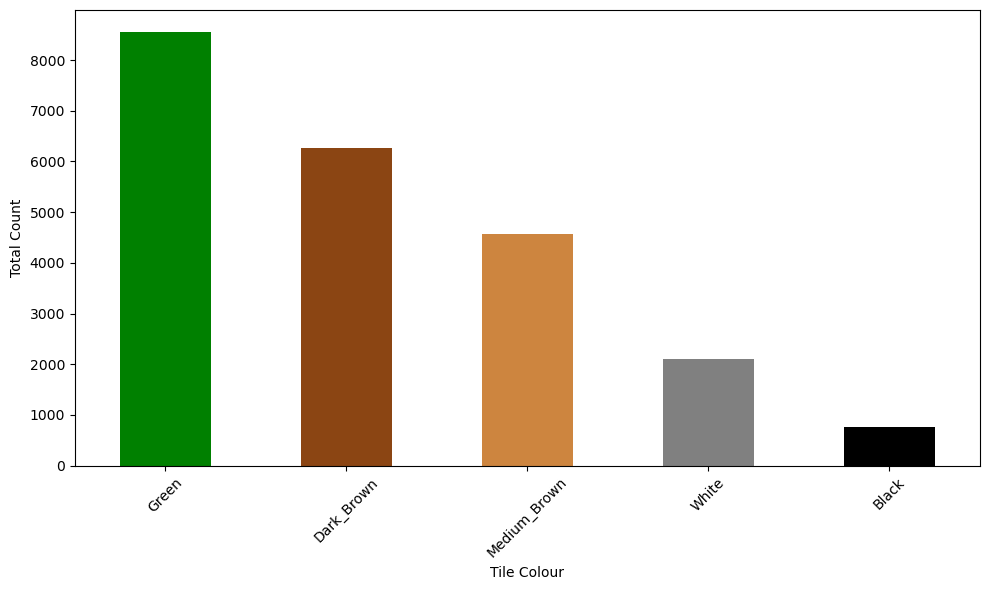

In [68]:
#Data reference

df=pd.read_csv('data/mtdillon_weather_bog_data_test2.csv')
df.head()
# Generate the list of column names dynamically
tile_columns = [f'tile_{i}' for i in range(256)]

# Select the columns from the DataFrame

X = df[['month', 'meant', 'maxtp', 'mintp', 'mnmax', 'mnmin', 'rain', 'gmin', 'wdsp', 'maxgt']]
y = df[tile_columns]



value_counts = y.stack().value_counts()
color_map = {
    'Black': 'black',
    'Dark_Brown': 'saddlebrown',
    'Green': 'green',
    'Medium_Brown': 'peru',
    'White': 'gray',
    # Add more colors as needed for other unique values
}

bar_colors = [color_map.get(value, 'skyblue') for value in value_counts.index]  # Default to 'skyblue' if a color is missing

# Plotting the bar chart with assigned colors
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar', color=bar_colors)
#plt.title("Each Value Across Tile Columns")
plt.xlabel("Tile Colour")
plt.ylabel("Total Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/total_tile_counts.png')
plt.show()


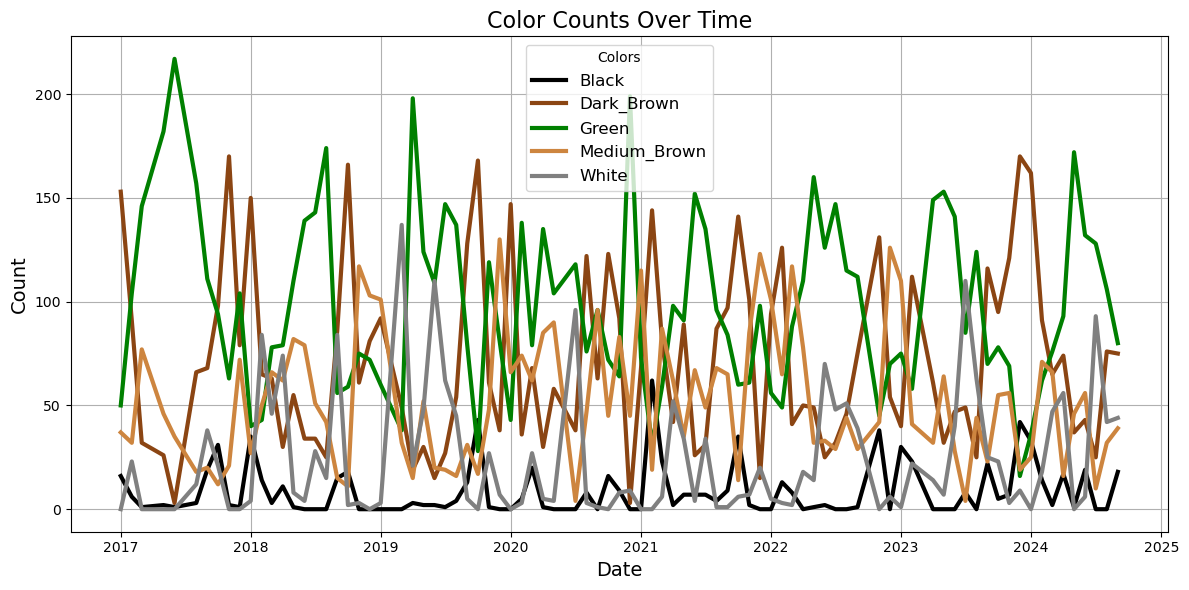

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data/mtdillon_weather_bog_data_test2.csv')

# Generate the list of tile column names dynamically
tile_columns = [f'tile_{i}' for i in range(256)]

# Combine year and month to create a datetime object
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))  # Assuming the day is always 1

# Select the tiles
y = df[tile_columns]

# Stack the tiles and include the date in the MultiIndex
stacked_y = y.stack()
stacked_y.index = pd.MultiIndex.from_tuples(
    [(df.loc[idx, 'date'], col) for idx, col in stacked_y.index],
    names=["date", "tile"]
)

# Calculate value counts grouped by date
color_counts_over_time = stacked_y.groupby(level=0).apply(lambda x: x.value_counts())

# Reset index for plotting
color_counts_df = color_counts_over_time.unstack(fill_value=0)

# Map colors for plotting
color_map = {
    'Black': 'black',
    'Dark_Brown': 'saddlebrown',
    'Green': 'green',
    'Medium_Brown': 'peru',
    'White': 'gray',
    # Add more colors if needed
}

# Plot the data
plt.figure(figsize=(12, 6))
for color, hex_color in color_map.items():
    if color in color_counts_df.columns:
        plt.plot(color_counts_df.index, color_counts_df[color], label=color, color=hex_color, linewidth=3)

# Add labels, legend, and title
plt.title('Color Counts Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Colors', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


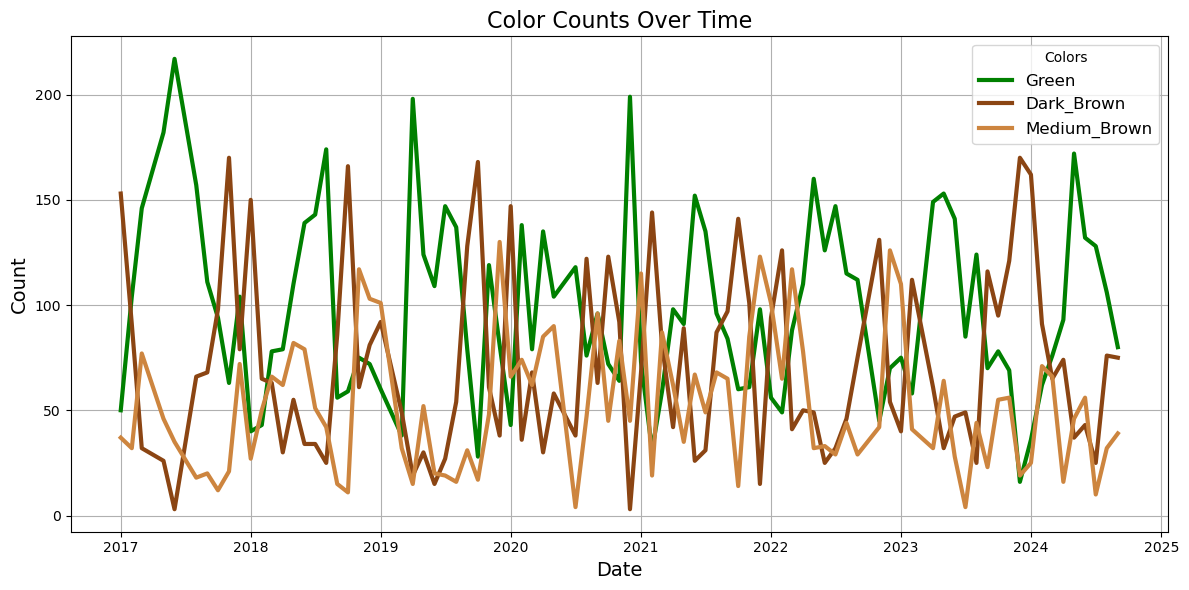

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data/mtdillon_weather_bog_data_test2.csv')

# Generate the list of tile column names dynamically
tile_columns = [f'tile_{i}' for i in range(256)]

# Combine year and month to create a datetime object
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))  # Assuming the day is always 1

# Select the tiles
y = df[tile_columns]

# Stack the tiles and include the date in the MultiIndex
stacked_y = y.stack()
stacked_y.index = pd.MultiIndex.from_tuples(
    [(df.loc[idx, 'date'], col) for idx, col in stacked_y.index],
    names=["date", "tile"]
)

# Calculate value counts grouped by date
color_counts_over_time = stacked_y.groupby(level=0).apply(lambda x: x.value_counts())

# Reset index for plotting
color_counts_df = color_counts_over_time.unstack(fill_value=0)

# Map colors for plotting
color_map = {
    'Black': 'black',
    'Dark_Brown': 'saddlebrown',
    'Green': 'green',
    'Medium_Brown': 'peru',
    'White': 'gray',
}


# Set the colors to be used in the plot
selected_colors = {color: color_map[color] for color in ['Green', 'Dark_Brown', 'Medium_Brown'] if color in color_counts_df.columns}

# Plot the data
plt.figure(figsize=(12, 6))
for color in selected_colors:
    if color in color_counts_df.columns:
        plt.plot(color_counts_df.index, color_counts_df[color], label=color, color=color_map[color], linewidth=3)

# Add labels, legend, and title
plt.title('Color Counts Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Colors', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


<Figure size 1200x600 with 0 Axes>

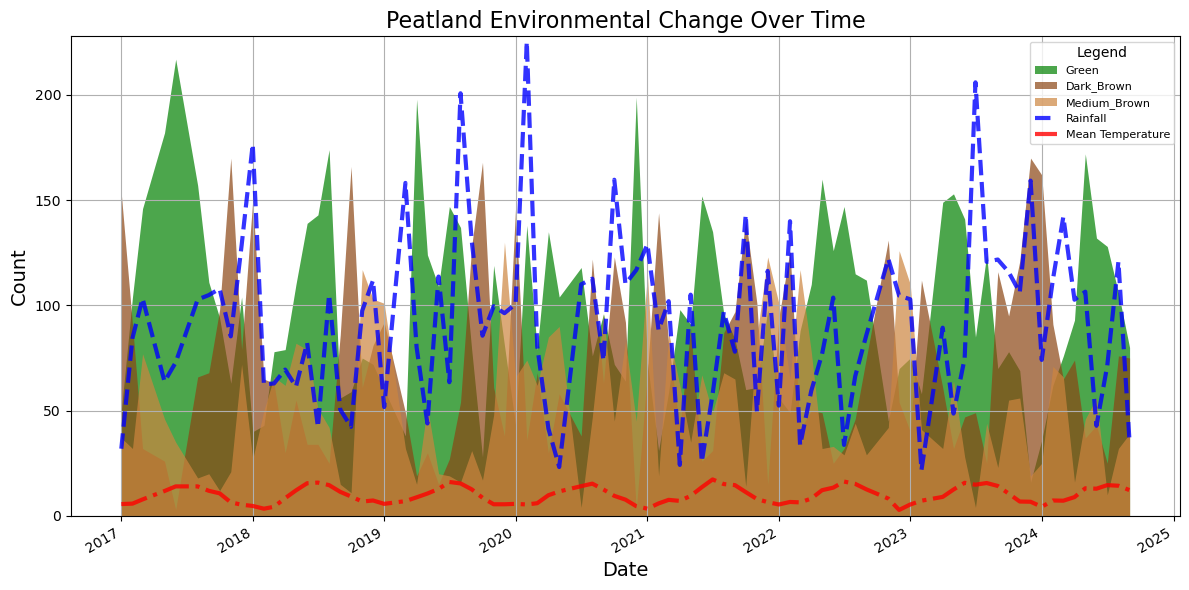

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data/mtdillon_weather_bog_data_test2.csv')

# Generate the list of tile column names dynamically
tile_columns = [f'tile_{i}' for i in range(256)]

# Select the tiles
y = df[tile_columns]

# Combine year and month to create a proper datetime column
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))  # Assuming day=1 for simplicity

# Stack the tile data
stacked_y = y.stack()

# Create a MultiIndex for the stacked data
stacked_y.index = pd.MultiIndex.from_tuples(
    [(df.loc[idx, 'date'], col) for idx, col in stacked_y.index],
    names=["date", "tile"]
)

# Calculate value counts grouped by date
color_counts_over_time = stacked_y.groupby(level=0).value_counts()

# Convert to DataFrame using unstack()
color_counts_df = color_counts_over_time.unstack(fill_value=0)

# Map colors for plotting
color_map = {
    'Black': 'black',
    'Dark_Brown': 'saddlebrown',
    'Green': 'green',
    'Medium_Brown': 'peru',
    'White': 'gray',
}

# Set the colors to be used in the plot
colors_to_use = {color: color_map[color] for color in ['Green', 'Dark_Brown', 'Medium_Brown'] if color in color_counts_df.columns}

# Plot the stacked area plot with custom colors
plt.figure(figsize=(12, 6))
color_counts_df[colors_to_use.keys()].plot.area(stacked=False, color=colors_to_use.values(), linewidth=0, alpha=0.7,figsize=(12, 6))

# Add labels, title, and legend
plt.title('Peatland Environmental Change Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(True)
plt.tight_layout()
# Add overlay lines for rain and meant
plt.plot(df['date'], df['rain'], label='Rainfall', color='blue', linestyle='--', linewidth=3, alpha=0.8)
plt.plot(df['date'], df['meant'], label='Mean Temperature', color='red', linestyle='-.', linewidth=3, alpha=0.8)

plt.legend(title='Legend', fontsize=8, loc='upper right')

# Show the plot
plt.show()


<Figure size 1200x600 with 0 Axes>

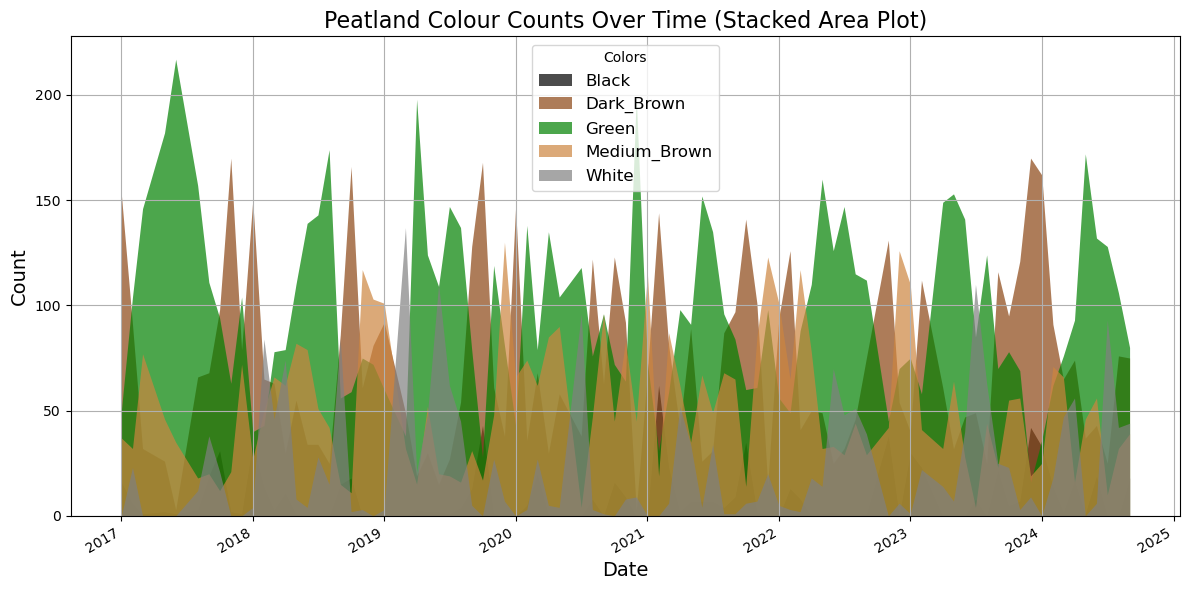

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data/mtdillon_weather_bog_data_test2.csv')

# Generate the list of tile column names dynamically
tile_columns = [f'tile_{i}' for i in range(256)]

# Select the tiles
y = df[tile_columns]

# Combine year and month to create a proper datetime column
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))  # Assuming day=1 for simplicity

# Stack the tile data
stacked_y = y.stack()

# Create a MultiIndex for the stacked data
stacked_y.index = pd.MultiIndex.from_tuples(
    [(df.loc[idx, 'date'], col) for idx, col in stacked_y.index],
    names=["date", "tile"]
)

# Calculate value counts grouped by date
color_counts_over_time = stacked_y.groupby(level=0).value_counts()

# Convert to DataFrame using unstack()
color_counts_df = color_counts_over_time.unstack(fill_value=0)

# Map colors for plotting
color_map = {
    'Black': 'black',
    'Dark_Brown': 'saddlebrown',
    'Green': 'green',
    'Medium_Brown': 'peru',
    'White': 'gray',
    # Add more colors if needed
}

# Set the colors to be used in the plot
colors_to_use = {color: color_map[color] for color in color_counts_df.columns if color in color_map}

# Plot the stacked area plot with custom colors
plt.figure(figsize=(12, 6))
color_counts_df[colors_to_use.keys()].plot.area(stacked=False, color=colors_to_use.values(), linewidth=0, alpha=0.7, figsize=(12, 6))

# Add labels, title, and legend
plt.title('Peatland Colour Counts Over Time (Stacked Area Plot)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Colors', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


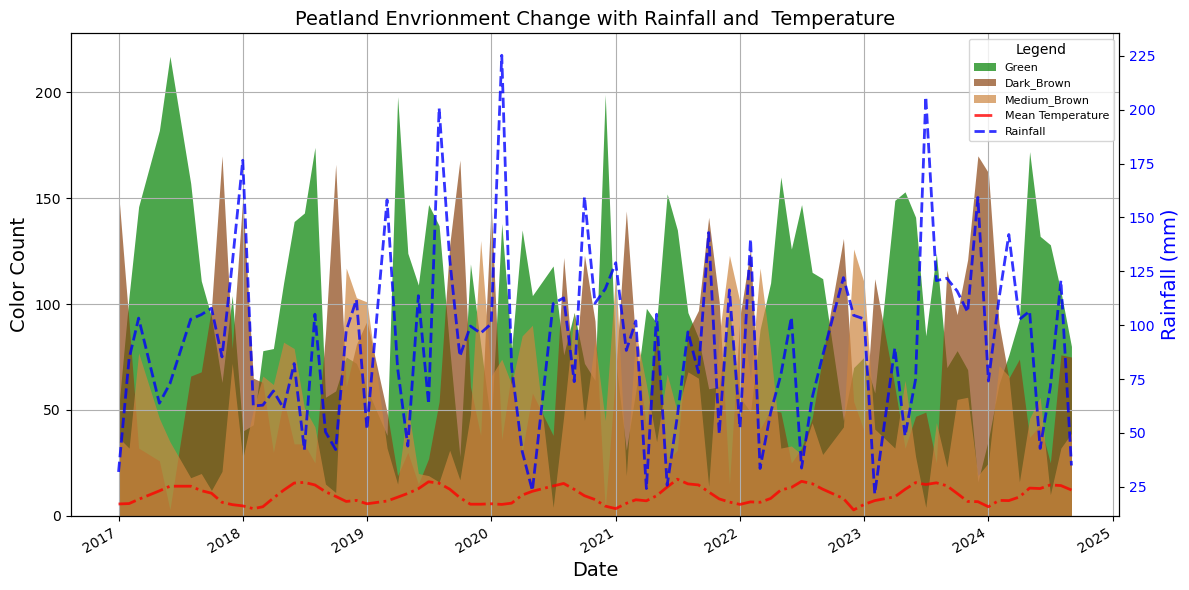

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data/mtdillon_weather_bog_data_test2.csv')

# Generate the list of tile column names dynamically
tile_columns = [f'tile_{i}' for i in range(256)]

# Select the tiles
y = df[tile_columns]

# Combine year and month to create a proper datetime column
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))  # Assuming day=1 for simplicity

# Stack the tile data
stacked_y = y.stack()

# Create a MultiIndex for the stacked data
stacked_y.index = pd.MultiIndex.from_tuples(
    [(df.loc[idx, 'date'], col) for idx, col in stacked_y.index],
    names=["date", "tile"]
)

# Calculate value counts grouped by date
color_counts_over_time = stacked_y.groupby(level=0).value_counts()

# Convert to DataFrame using unstack()
color_counts_df = color_counts_over_time.unstack(fill_value=0)

# Map colors for plotting
color_map = {
    'Black': 'black',
    'Dark_Brown': 'saddlebrown',
    'Green': 'green',
    'Medium_Brown': 'peru',
    'White': 'gray',
}

# Set the colors to be used in the plot
colors_to_use = {color: color_map[color] for color in ['Green', 'Dark_Brown', 'Medium_Brown'] if color in color_counts_df.columns}

# Create the primary plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot unstacked area for the peatland color counts
color_counts_df[colors_to_use.keys()].plot.area(
    ax=ax1,
    stacked=False,
    color=colors_to_use.values(),
    linewidth=0,
    alpha=0.7
)

# Customize primary y-axis (for counts)
ax1.set_ylabel('Color Count', fontsize=14)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_title('Peatland Envrionment Change with Rainfall and  Temperature', fontsize=14)
ax1.legend(title='Colors', fontsize=8, loc='upper left')
ax1.grid(True)

# Add a secondary y-axis for rainfall
ax2 = ax1.twinx()
ax2.plot(df['date'], df['rain'], label='Rainfall', color='blue', linestyle='--', linewidth=2, alpha=0.8)
ax2.set_ylabel('Rainfall (mm)', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add the mean temperature overlay to the primary axis
ax1.plot(df['date'], df['meant'], label='Mean Temperature', color='red', linestyle='-.', linewidth=2, alpha=0.8)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, title='Legend', fontsize=8, loc='upper right')

# Tight layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()


In [109]:


# Define features and target

df=pd.read_csv('data/mtdillon_weather_bog_data_test2.csv')
df.head()
# Generate the list of column names dynamically


# Select the columns from the DataFrame

X = df[['month', 'meant', 'maxtp', 'mintp', 'mnmax', 'mnmin', 'rain', 'gmin', 'wdsp', 'maxgt']]
tile_columns = [f'tile_{i}' for i in range(256)]
y = df[tile_columns]


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

print(len(X_train))
print(len(X_test))
# Scale the features
#scalar=StandardScaler()
scalar=MinMaxScaler()
scalar.fit(X_train)

X_train = scalar.transform(X_train)
X_test=scalar.transform(X_test)
# Initialize MultiOutputClassifier with KNeighborsClassifier
multi_output_knn = KNeighborsClassifier(n_neighbors=5)
#multi_output_knn = MultiOutputClassifier(knn)
multi_output_knn.fit(X_train, y_train)

# Predict on test set
yPredict = multi_output_knn.predict(X_test)

from sklearn.metrics import accuracy_score

# Initialize list to store per-target accuracy
accuracies = []

# Calculate accuracy for each target column individually
for i, col in enumerate(y.columns):
    y_test_col = y_test.iloc[:, i]
    y_pred_col = yPredict[:, i]
    col_accuracy = accuracy_score(y_test_col, y_pred_col)
    accuracies.append(col_accuracy)
    print(f"Accuracy for {col.replace('tile','section')}: {col_accuracy}")
    cm = confusion_matrix(y_test_col, y_pred_col)

 #   print('Confusion Matrix')
 #   print(cm)

# Calculate mean accuracy across all target columns
overall_accuracy = sum(accuracies) / len(accuracies)
min_accuracy = min(accuracies)
max_accuracy = max(accuracies)
print("Overall Accuracy:", overall_accuracy)
print("Min Accuracy:", min_accuracy)
print("Max Accuracy:", max_accuracy)

X_test_original = scalar.inverse_transform(X_test)
yPredict_df = pd.DataFrame(yPredict, columns=y.columns)
X_test_df = pd.DataFrame(X_test_original, columns=X.columns)
y_test_df = y_test.reset_index(drop=True)

# Concatenate inputs, actual values, and predicted values
output_df = pd.concat([X_test_df, y_test_df.add_prefix('Actual_'), yPredict_df.add_prefix('Predicted_')], axis=1)

# Save to CSV
output_df.to_csv("data\predictions_output.csv", index=False)

print("Predictions and actual values saved to predictions_output.csv")




69
18
Accuracy for section_0: 0.7222222222222222
Accuracy for section_1: 0.8888888888888888
Accuracy for section_2: 0.7777777777777778
Accuracy for section_3: 0.8888888888888888
Accuracy for section_4: 0.3888888888888889
Accuracy for section_5: 0.6111111111111112
Accuracy for section_6: 0.5
Accuracy for section_7: 0.6666666666666666
Accuracy for section_8: 0.4444444444444444
Accuracy for section_9: 0.5555555555555556
Accuracy for section_10: 0.7777777777777778
Accuracy for section_11: 0.8333333333333334
Accuracy for section_12: 0.1111111111111111
Accuracy for section_13: 0.3333333333333333
Accuracy for section_14: 0.6111111111111112
Accuracy for section_15: 0.4444444444444444
Accuracy for section_16: 0.5
Accuracy for section_17: 0.5
Accuracy for section_18: 0.3888888888888889
Accuracy for section_19: 0.2777777777777778
Accuracy for section_20: 0.2777777777777778
Accuracy for section_21: 0.2777777777777778
Accuracy for section_22: 0.4444444444444444
Accuracy for section_23: 0.3888888888

In [116]:
df=pd.read_csv('data/2025_Weather.csv')
df.head()
# Generate the list of column names dynamically


# Select the columns from the DataFrame

X_2025 = df[['month', 'meant', 'maxtp', 'mintp', 'mnmax', 'mnmin', 'rain', 'gmin', 'wdsp', 'maxgt']]
X_2025_scaled=scalar.transform(X_2025)
yPredict = multi_output_knn.predict(X_2025.values)
print(yPredict)
# Convert yPredict (NumPy array) to a DataFrame
yPredict_df = pd.DataFrame(yPredict, columns=[f'tile_{i}' for i in range(yPredict.shape[1])])

yPredict_df.to_csv('data\predicted_tiles_2025.csv')

[['Green' 'Green' 'Green' ... 'Green' 'Dark_Brown' 'Green']
 ['Green' 'Green' 'Green' ... 'Green' 'Dark_Brown' 'Green']
 ['Green' 'Green' 'Green' ... 'Green' 'Dark_Brown' 'Green']
 ...
 ['Green' 'Green' 'Green' ... 'Green' 'Dark_Brown' 'Dark_Brown']
 ['Green' 'Green' 'Green' ... 'Green' 'Dark_Brown' 'Dark_Brown']
 ['Green' 'Green' 'Green' ... 'Green' 'Dark_Brown' 'Green']]


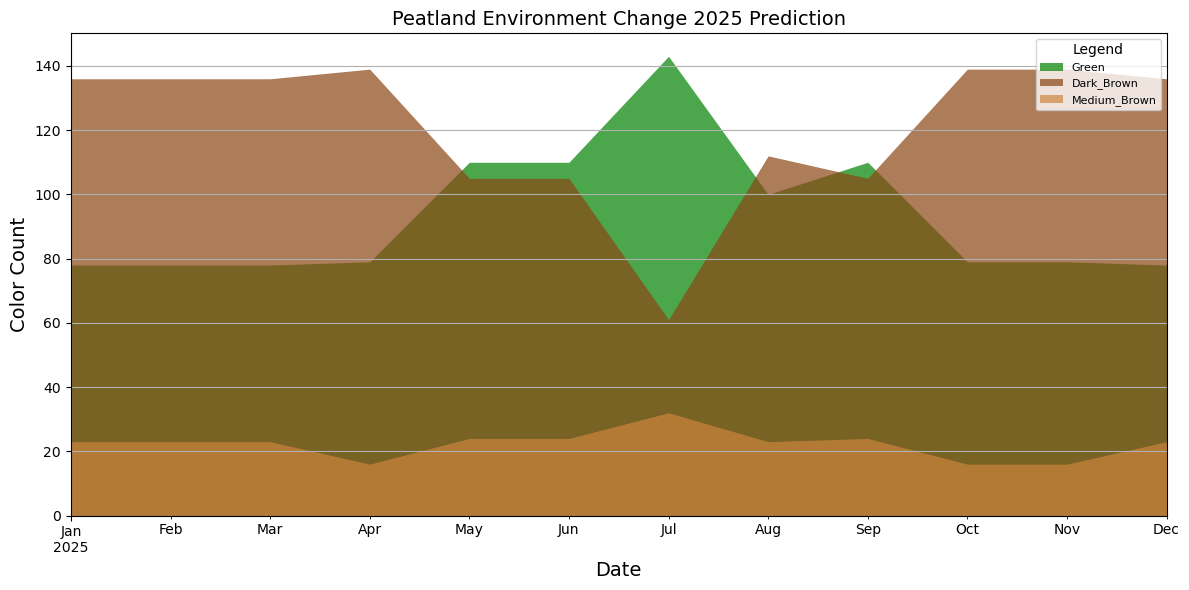

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data/2025_weather.csv')

# Generate the list of tile column names dynamically
tile_columns = [f'tile_{i}' for i in range(256)]

# Select the tiles
y = df[tile_columns]

# Combine year and month to create a proper datetime column
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))  # Assuming day=1 for simplicity

# Stack the tile data
stacked_y = y.stack()

# Create a MultiIndex for the stacked data
stacked_y.index = pd.MultiIndex.from_tuples(
    [(df.loc[idx, 'date'], col) for idx, col in stacked_y.index],
    names=["date", "tile"]
)

# Calculate value counts grouped by date
color_counts_over_time = stacked_y.groupby(level=0).value_counts()

# Convert to DataFrame using unstack()
color_counts_df = color_counts_over_time.unstack(fill_value=0)

# Map colors for plotting
color_map = {
    'Black': 'black',
    'Dark_Brown': 'saddlebrown',
    'Green': 'green',
    'Medium_Brown': 'peru',
    'White': 'gray',
}

# Set the colors to be used in the plot
colors_to_use = {color: color_map[color] for color in ['Green', 'Dark_Brown', 'Medium_Brown'] if color in color_counts_df.columns}

# Create the primary plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot unstacked area for the peatland color counts
color_counts_df[colors_to_use.keys()].plot.area(
    ax=ax1,
    stacked=False,
    color=colors_to_use.values(),
    linewidth=0,
    alpha=0.7
)

# Customize primary y-axis (for counts)
ax1.set_ylabel('Color Count', fontsize=14)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_title('Peatland Environment Change 2025 Prediction', fontsize=14)
ax1.legend(title='Colors', fontsize=8, loc='upper left')
ax1.grid(True)


# Add the mean temperature overlay to the primary axis
#ax1.plot(df['date'], df['meant'], label='Mean Temperature', color='red', linestyle='-.', linewidth=2, alpha=0.8)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, title='Legend', fontsize=8, loc='upper right')

# Tight layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd

# Assuming yPredict is a NumPy array with predictions
# Create a DataFrame for the predictions
yPredict_df = pd.DataFrame(yPredict, columns=[f'tile_{i}' for i in range(yPredict.shape[1])])

# Optionally, include the input features for reference
result_df = pd.concat([df[['month', 'meant', 'maxtp', 'mintp', 'mnmax', 'mnmin', 'rain', 'gmin', 'wdsp', 'maxgt']], yPredict_df], axis=1)

# Save the predictions to a CSV file
output_file = 'data\predicted_tiles_2025.csv'
result_df.to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

X_test_original = scalar.inverse_transform(X_test)

print(len(X_test

feature_descriptions = {'month': 'Month'
                        ,'rain': 'Precipitation Amount (mm)'
                        ,'meant': 'Mean Air Temperature (C)'
                        ,'maxtp': 'Maximum Air Temperature (C)'
                        ,'mintp': 'Minimum Air Temperature (C)'
                        ,'mnmax':'Mean Maximum Temperature (C)'
                        ,'mnmin':'Mean Minimum Temperature (C)'
                        ,'gmin': 'Grass Minimum Temperature (C)'
                        ,'wdsp': 'Mean Wind Speed (knot)'
                        ,'maxgt': 'Highest Gust (knot)'
                        ,'sun': 'Sunshine duration (knot)'
                        ,'ind': 'Inidicator'}


# Iterate over predictions and count occurrences of each classification type
for i, (input_row, pred_row) in enumerate(zip(X_test_original, yPredict)):
  #  print(f"Prediction for Test Sample {i+1}:")
    
    # Print input values
    print("Weather and date Values:")
    for feature_name, value in zip(X.columns, input_row):
        print(f"  {feature_descriptions[feature_name]}: {value:.2f}")
    
   # table_data = [[feature_name, f"{value:.2f}"] for feature_name, value in zip(X.columns, input_row)]
    headers = [feature_name for feature_name in X.columns]
    values = [f"{value:.2f}" for value in input_row]
    table_data = [headers, values]

    # Create the table
    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed
    ax.axis('off')  # Hide axes
    # Create the table
    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed
    ax.axis('off')  # Hide axes
    
    # Create the table
    table = ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)  # Scale table size
    #table.title('Weather values'
 
    
    # Set borders for table cells
    for key, cell in table.get_celld().items():
        cell.set_edgecolor('black')
        cell.set_linewidth(1.5)
        if key[0] == 0:  # Header row
            cell.set_text_props(weight='bold')
            cell.set_facecolor("#d3d3d3")  # Light gray background for header
    
    plt.title("Weather and Date Values")
    plt.show()  # Display the table
    # Count occurrences of each classification type in the row
    count_colours = Counter(pred_row)
    labels = list(count_colours.keys())
    values = list(count_colours.values())
    target_colours_chart=[]

    for label in labels:
        target_colours_chart.append(target_colours[target_colours_names.index(label)])
    target_colours_rgba = [(r/255, g/255, b/255, 1) for r, g, b in target_colours_chart]
    
    plt.figure(figsize=(8, 8))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=target_colours_rgba)
    plt.title('Mt Dillon Bogland Overview ')
    
    plt.savefig(f'data\AssignmentCharts\Mt_Dillon_Bogland_Overview{i}.pdf') 
    plt.show()
    plt.close()    # Close the figure after saving

 
    
    print("\n" + "-"*40 + "\n") 